In [1]:
# ============================================
# 📦 Step 1: Import Libraries
# ============================================
import os
import sys
import warnings
warnings.filterwarnings('ignore')
os.environ['OPENCV_LOG_LEVEL'] = 'SILENT'  # Suppress libpng ICC warnings

CUSTOM_DATA_PATH = "datasets"
os.makedirs(CUSTOM_DATA_PATH, exist_ok=True)
os.environ['KAGGLEHUB_CACHE'] = CUSTOM_DATA_PATH  # older versions
os.environ['KAGGLE_CACHE_DIR'] = CUSTOM_DATA_PATH  # some versions
os.environ['KAGGLEHUB_HOME'] = CUSTOM_DATA_PATH    # newer versions

import sys, copy, math, random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, precision_recall_curve

try:
    import kagglehub
except ImportError:
    pass


print("✅ All libraries imported")

# ImageNet normalization (pretrained ViT expects this)
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Device: {device}")

✅ All libraries imported
🖥️ Device: cuda


In [2]:
# ============================================
# 📁 Step 2: Download and Load Dataset
# ============================================

# Specify your custom folder path here
CUSTOM_DATA_PATH = "datasets"  # Change this to your desired folder
os.makedirs(CUSTOM_DATA_PATH, exist_ok=True)
os.environ['KAGGLEHUB_HOME'] = CUSTOM_DATA_PATH

IN_KAGGLE = os.path.exists('/kaggle/input')

if IN_KAGGLE:
    BASE_PATH = Path('/kaggle/input/nih-chest-xrays')
else:
    path = kagglehub.dataset_download("nih-chest-xrays/data")
    BASE_PATH = Path(path)

print(f"📂 Base path: {BASE_PATH}")

# Load metadata
csv_path = BASE_PATH / 'Data_Entry_2017.csv'
df = pd.read_csv(csv_path)

DISEASE_CATEGORIES = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass',
    'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema',
    'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'
]

for disease in DISEASE_CATEGORIES:
    df[disease] = df['Finding Labels'].apply(lambda x: 1 if disease in x else 0)

# Find image paths
image_dirs = list(BASE_PATH.glob('images_*/images'))
if not image_dirs:
    image_dirs = [BASE_PATH / 'images']

image_map = {}
for d in image_dirs:
    for f in d.iterdir():
        if f.suffix == '.png':
            image_map[f.name] = str(f)

df['Image Path'] = df['Image Index'].map(image_map)
df = df.dropna(subset=['Image Path']).reset_index(drop=True)

print(f"✅ Loaded {len(df):,} images with {len(DISEASE_CATEGORIES)} disease labels")
print(f"📂 Image directories: {len(image_dirs)}")

📂 Base path: datasets/datasets/nih-chest-xrays/data/versions/3
✅ Loaded 112,120 images with 14 disease labels
📂 Image directories: 12


In [3]:
# ============================================
# ⚙️ Step 3: Configuration
# ============================================

OPTION_NAME = "option7_anatomy_masked_attention_ssl"

class Config:
    # ViT-Small settings (matches timm vit_small_patch16_224)
    img_size = 224
    patch_size = 16
    num_patches = (224 // 16) ** 2  # 196
    embed_dim = 384          # ViT-Small (was 192 for Tiny)
    num_heads = 6            # ViT-Small (was 3 for Tiny)
    depth = 12
    mlp_ratio = 4.0

    # Pretrained settings
    use_pretrained = True    # Load ImageNet pretrained weights
    freeze_epochs = 5        # Freeze encoder for first N SSL epochs

    # SSL
    feat_dim = 384           # Match embed_dim
    proj_dim = 128
    mask_ratio = 0.5
    momentum = 0.996
    lambda_attn = 0.05
    lambda_contrastive = 1.0   # contrastive loss weight

    # Training
    batch_size = 64          # Reduced due to larger model
    pretrain_epochs = 50
    finetune_epochs = 100
    lr_pretrain = 1e-4
    lr_finetune = 5e-4

    device = device

cfg = Config()

if IN_KAGGLE:
    CHECKPOINT_DIR = f'/kaggle/working/checkpoints_{OPTION_NAME}'
else:
    CHECKPOINT_DIR = f'./checkpoints_{OPTION_NAME}'

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print("✅ Configuration ready")
print(f"   ViT-Small: embed_dim={cfg.embed_dim}, heads={cfg.num_heads}, depth={cfg.depth}")
print(f"   Pretrained: {cfg.use_pretrained}, Freeze epochs: {cfg.freeze_epochs}")
print(f"   Patches: {cfg.num_patches}, mask_ratio={cfg.mask_ratio}")
print(f"   Checkpoint dir: {CHECKPOINT_DIR}")


✅ Configuration ready
   ViT-Small: embed_dim=384, heads=6, depth=12
   Pretrained: True, Freeze epochs: 5
   Patches: 196, mask_ratio=0.5
   Checkpoint dir: ./checkpoints_option7_anatomy_masked_attention_ssl


In [4]:
# ============================================
# 💾 Step 3.5: Checkpoint & Resume Configuration
# ============================================

RESUME_SSL_PRETRAINING = True
RESUME_FINETUNING = True
SSL_CHECKPOINT_FILE = "latest"
FINETUNE_CHECKPOINT_FILE = "latest"
SAVE_EVERY_SSL = 5
SAVE_EVERY_FT = 5

def save_checkpoint(state, filename):
    path = os.path.join(CHECKPOINT_DIR, filename)
    torch.save(state, path)

def load_checkpoint(filename):
    path = os.path.join(CHECKPOINT_DIR, filename)
    if os.path.exists(path):
        return torch.load(path, map_location=cfg.device, weights_only=False)
    return None

print("✅ Checkpoint utilities ready")

✅ Checkpoint utilities ready


In [5]:
# ============================================
# Step 4: Load Pre-Computed Lung Masks
# ============================================
# Masks pre-computed by precompute_lung_masks.ipynb
# Replaces segment_lungs() and lung_mask_to_patch_mask()

if IN_KAGGLE:
    PATCH_MASK_DIR = '/kaggle/working/lung_masks/patch_masks'
else:
    PATCH_MASK_DIR = './lung_masks/patch_masks'

def load_precomputed_patch_masks(dataframe, mask_dir=PATCH_MASK_DIR):
    """Bulk-load all patch masks for a dataframe into a list."""
    masks = []
    missing = 0
    for img_name in tqdm(dataframe["Image Index"], desc="Loading patch masks"):
        mask_name = img_name.replace(".png", "")
        mask_path = os.path.join(mask_dir, f"{mask_name}.npy")
        if os.path.exists(mask_path):
            masks.append(np.load(mask_path))
        else:
            # Fallback: all-ones mask (treat entire image as lung)
            masks.append(np.ones(196, dtype=np.float32))
            missing += 1
    if missing > 0:
        print(f"Warning: {missing} masks not found, using all-ones fallback")
    print(f"Loaded {len(masks)} patch masks from {mask_dir}")
    return masks

print(f"Patch mask directory: {PATCH_MASK_DIR}")


Patch mask directory: ./lung_masks/patch_masks


In [6]:
# ============================================
# 🔄 Step 5: Data Augmentation
# ============================================

class ChestXrayAugment:
    """Strong augmentations for chest X-ray SSL (cv2-based for speed)."""

    def __init__(self, img_size=224):
        self.img_size = img_size

    def __call__(self, img):
        """img: numpy array (H, W) float32 [0,1]"""
        if isinstance(img, torch.Tensor):
            img = img.numpy()
        if img.ndim == 3 and img.shape[0] == 1:
            img = img[0]

        h, w = img.shape[:2]

        # Random resized crop (0.8-1.0 scale) — like danny-mobilenet
        if random.random() < 0.8:
            crop_scale = random.uniform(0.8, 1.0)
            ch, cw = int(h * crop_scale), int(w * crop_scale)
            top = random.randint(0, h - ch)
            left = random.randint(0, w - cw)
            img = img[top:top+ch, left:left+cw]
            img = cv2.resize(img, (self.img_size, self.img_size), interpolation=cv2.INTER_LINEAR)

        # Random horizontal flip
        if random.random() < 0.5:
            img = np.fliplr(img).copy()

        # Random rotation
        if random.random() < 0.7:
            angle = random.uniform(-10, 10)
            h, w = img.shape[:2]
            M = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1.0)
            img = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REPLICATE)

        # Brightness
        if random.random() < 0.8:
            factor = 1 + random.uniform(-0.15, 0.15)
            img = np.clip(img * factor, 0, 1)

        # Contrast
        if random.random() < 0.8:
            mean = img.mean()
            factor = random.uniform(0.85, 1.15)
            img = np.clip((img - mean) * factor + mean, 0, 1)

        # Gaussian noise
        if random.random() < 0.3:
            noise = np.random.randn(*img.shape).astype(np.float32) * 0.03
            img = np.clip(img + noise, 0, 1)

        return img.astype(np.float32)


def to_3ch_imagenet(img_gray):
    """Convert grayscale (H,W) [0,1] → 3-channel ImageNet-normalized tensor (3,H,W)."""
    # Stack grayscale to 3 channels
    img_3ch = np.stack([img_gray, img_gray, img_gray], axis=-1)  # (H,W,3)
    # ImageNet normalization
    img_3ch = (img_3ch - IMAGENET_MEAN) / IMAGENET_STD
    # HWC → CHW
    img_3ch = img_3ch.transpose(2, 0, 1)  # (3,H,W)
    return torch.from_numpy(img_3ch).float()


augment = ChestXrayAugment(cfg.img_size)
print("✅ Augmentation pipeline ready (with random crop + ImageNet normalization)")


✅ Augmentation pipeline ready (with random crop + ImageNet normalization)


In [7]:
# ============================================
# 📦 Step 6: Dataset Classes
# ============================================

class Option7SSLDataset(Dataset):
    """SSL dataset returning TWO independently augmented views for contrastive learning."""

    def __init__(self, df, precomputed_patch_masks, img_size=224, augment_fn=None):
        self.df = df.copy().reset_index(drop=True)
        self.patch_masks = precomputed_patch_masks
        self.img_size = img_size
        self.augment_fn = augment_fn
        self.paths = df['Image Path'].tolist()
        print(f"📦 Option7SSLDataset: {len(self.df)} samples (two-view contrastive, ImageNet norm)")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_np = cv2.imread(self.paths[idx], cv2.IMREAD_GRAYSCALE)
        img_np = cv2.resize(img_np, (self.img_size, self.img_size), interpolation=cv2.INTER_LINEAR)
        img_np = img_np.astype(np.float32) / 255.0

        patch_mask = self.patch_masks[idx]

        # Generate TWO independent augmentation views (SimCLR-style)
        if self.augment_fn:
            view1_np = self.augment_fn(img_np.copy())
            view2_np = self.augment_fn(img_np.copy())
        else:
            view1_np = img_np.copy()
            view2_np = img_np.copy()

        # 3-channel + ImageNet normalization
        view1 = to_3ch_imagenet(view1_np)  # (3, H, W)
        view2 = to_3ch_imagenet(view2_np)  # (3, H, W)
        patch_mask_tensor = torch.from_numpy(patch_mask)

        return view1, view2, patch_mask_tensor


class ClassificationDataset(Dataset):
    """Multi-label classification with 3-channel ImageNet-normalized output."""

    def __init__(self, df, disease_categories, img_size=224, is_training=False):
        self.df = df.copy().reset_index(drop=True)
        self.disease_categories = disease_categories
        self.img_size = img_size
        self.is_training = is_training
        self.labels = torch.tensor(df[disease_categories].values.astype(np.float32))
        self.paths = df['Image Path'].tolist()
        print(f"📦 ClassificationDataset: {len(self.df)} samples (training={is_training})")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_np = cv2.imread(self.paths[idx], cv2.IMREAD_GRAYSCALE)
        img_np = cv2.resize(img_np, (self.img_size, self.img_size), interpolation=cv2.INTER_LINEAR)
        img_np = img_np.astype(np.float32) / 255.0

        if self.is_training:
            # Random resized crop
            if random.random() < 0.8:
                h, w = img_np.shape[:2]
                crop_scale = random.uniform(0.8, 1.0)
                ch, cw = int(h * crop_scale), int(w * crop_scale)
                top = random.randint(0, h - ch)
                left = random.randint(0, w - cw)
                img_np = img_np[top:top+ch, left:left+cw]
                img_np = cv2.resize(img_np, (self.img_size, self.img_size))
            if random.random() < 0.5:
                img_np = np.fliplr(img_np).copy()
            # Brightness
            factor = 1 + random.uniform(-0.1, 0.1)
            img_np = np.clip(img_np * factor, 0, 1)
            # Contrast
            mean = img_np.mean()
            cfactor = random.uniform(0.9, 1.1)
            img_np = np.clip((img_np - mean) * cfactor + mean, 0, 1)

        img_tensor = to_3ch_imagenet(img_np)  # (3, H, W)
        return img_tensor, self.labels[idx]


print("✅ Dataset classes defined (3-channel, ImageNet normalization)")


✅ Dataset classes defined (3-channel, ImageNet normalization)


In [8]:
# ============================================
# 🏗️ Step 7: Pretrained ViT-Small Encoder & Momentum Teacher
# ============================================

class ViTEncoder(nn.Module):
    """ViT-Small encoder built on timm, exposing attention maps.
    
    Uses pretrained ImageNet weights, adapted for 1-channel grayscale input.
    Attention maps are captured via forward hooks for the attention alignment loss.
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3,
                 embed_dim=384, depth=12, num_heads=6, mlp_ratio=4.0,
                 use_pretrained=True):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_patches = (img_size // patch_size) ** 2
        
        # Load pretrained ViT-Small from timm
        self.vit = timm.create_model(
            'vit_small_patch16_224',
            pretrained=use_pretrained,
            in_chans=3,  # Load with 3 channels first, then adapt
            num_classes=0,  # Remove classification head
            img_size=img_size,
        )
        
        
        # Storage for attention weights (populated by hooks)
        self._attn_weights = [None] * len(self.vit.blocks)
        self._hooks = []
        self._register_attn_hooks()
    
    def _register_attn_hooks(self):
        """Register forward hooks to capture attention weights from each block."""
        for i, block in enumerate(self.vit.blocks):
            def hook_fn(module, input, output, idx=i):
                # timm's Attention module computes attn internally
                # We need to recompute it from q, k for extraction
                pass  # We'll use a different approach below
            # Instead, we override forward to capture attention
        self._patch_attention_forward()
    
    def _patch_attention_forward(self):
        """Patch each block's attention to store attention weights."""
        for i, block in enumerate(self.vit.blocks):
            original_attn_forward = block.attn.forward
            attn_weights_store = self._attn_weights
            block_idx = i
            
            def make_new_forward(orig_fn, store, idx):
                def new_forward(x, **kwargs):
                    B, N, C = x.shape
                    qkv = block.attn.qkv(x).reshape(B, N, 3, block.attn.num_heads, C // block.attn.num_heads)
                    qkv = qkv.permute(2, 0, 3, 1, 4)
                    q, k, v = qkv.unbind(0)
                    
                    scale = (C // block.attn.num_heads) ** -0.5
                    attn = (q @ k.transpose(-2, -1)) * scale
                    attn = attn.softmax(dim=-1)
                    store[idx] = attn  # Save attention weights
                    
                    attn_dropped = block.attn.attn_drop(attn)
                    x_out = (attn_dropped @ v).transpose(1, 2).reshape(B, N, C)
                    x_out = block.attn.proj(x_out)
                    x_out = block.attn.proj_drop(x_out)
                    return x_out
                return new_forward
            
            block.attn.forward = make_new_forward(original_attn_forward, attn_weights_store, block_idx)
    
    def forward(self, x):
        """Forward pass returning all tokens (CLS + patches)."""
        # Use timm's forward_features but return all tokens
        x = self.vit.patch_embed(x)
        cls_token = self.vit.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.vit.pos_embed
        x = self.vit.pos_drop(x)
        
        for blk in self.vit.blocks:
            x = blk(x)
        
        x = self.vit.norm(x)
        return x  # (B, 1+N, D)
    
    def get_attention_maps(self):
        """Return attention weight tensors from each block."""
        return list(self._attn_weights)


class ProjectionHead(nn.Module):
    """Projection head for contrastive learning on CLS tokens."""
    def __init__(self, embed_dim=384, proj_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.BatchNorm1d(embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, proj_dim),
        )
    def forward(self, x):
        return self.net(x)


class ReconstructionHead(nn.Module):
    """MLP head to reconstruct masked patch features."""
    def __init__(self, embed_dim=384, hidden_dim=768):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, embed_dim),
        )
    def forward(self, x):
        return self.net(x)


class Classifier(nn.Module):
    """2-layer MLP classifier with LayerNorm + Dropout for better generalization."""
    def __init__(self, feat_dim=384, num_classes=14, dropout=0.3):
        super().__init__()
        self.head = nn.Sequential(
            nn.LayerNorm(feat_dim),
            nn.Linear(feat_dim, feat_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(feat_dim // 2, num_classes),
        )
    def forward(self, x):
        return self.head(x)



# ── Momentum Teacher Utilities ──
@torch.no_grad()
def ema_update(online, teacher, momentum):
    """Exponential moving average update for teacher."""
    for p_o, p_t in zip(online.parameters(), teacher.parameters()):
        p_t.data.mul_(momentum).add_(p_o.data, alpha=1.0 - momentum)


def freeze_encoder(encoder):
    """Freeze all encoder parameters except patch embedding (for initial SSL warm-up)."""
    for name, param in encoder.named_parameters():
        # Keep patch embedding trainable so it can adapt to chest X-ray features
        param.requires_grad = 'patch_embed' in name
    print("🔒 Encoder frozen (patch_embed trainable)")


def unfreeze_encoder(encoder):
    """Unfreeze all encoder parameters."""
    for param in encoder.parameters():
        param.requires_grad = True
    print("🔓 Encoder unfrozen — all parameters trainable")


# ── Initialize models ──
online_encoder = ViTEncoder(
    img_size=cfg.img_size, patch_size=cfg.patch_size, in_chans=3,
    embed_dim=cfg.embed_dim, depth=cfg.depth,
    num_heads=cfg.num_heads, mlp_ratio=cfg.mlp_ratio,
    use_pretrained=cfg.use_pretrained
).to(cfg.device)

teacher_encoder = copy.deepcopy(online_encoder)
for p in teacher_encoder.parameters():
    p.requires_grad = False

recon_head = ReconstructionHead(cfg.embed_dim, cfg.embed_dim * 2).to(cfg.device)
proj_head = ProjectionHead(cfg.embed_dim, cfg.proj_dim).to(cfg.device)

total_params = sum(p.numel() for p in online_encoder.parameters())
print(f"✅ Models initialized (pretrained={cfg.use_pretrained})")
print(f"   Online ViT-Small : {total_params:,} params")
print(f"   Recon head       : {sum(p.numel() for p in recon_head.parameters()):,} params")
print(f"   Freeze epochs    : {cfg.freeze_epochs}")


✅ Models initialized (pretrained=True)
   Online ViT-Small : 21,665,664 params
   Recon head       : 590,976 params
   Freeze epochs    : 5


In [9]:
# ============================================
# 📉 Step 8: Loss Functions
# ============================================

def masked_reconstruction_loss(recon, target, mask):
    """
    MSE reconstruction loss on masked patch positions only.
    
    Args:
        recon:  (B, N, D) reconstructed patch embeddings
        target: (B, N, D) teacher patch embeddings (reconstruction target)
        mask:   (B, N)   binary mask (1 = masked/reconstruct, 0 = visible)
    Returns:
        Scalar loss: mean squared error averaged over masked positions
    """
    mask_exp = mask.unsqueeze(-1)  # (B, N, 1)
    diff = (recon - target) ** 2   # (B, N, D)
    return (diff * mask_exp).sum() / mask_exp.sum().clamp(min=1.0)


def attention_alignment_loss(attn_maps, patch_masks):
    """
    Soft attention guidance: encourage CLS token to attend to lung patches.
    Uses cross-entropy between CLS-to-patch attention and a soft lung prior.
    
    Args:
        attn_maps:   list of (B, H, T, T) attention tensors (T = 1+N, includes CLS)
        patch_masks: (B, N) lung patch masks (1 = lung, 0 = background)
    Returns:
        Scalar loss averaged across layers and heads
    """
    total_loss = 0.0
    n_layers = 0
    for attn in attn_maps:
        if attn is None:
            continue
        # CLS-to-patch attention: row 0, cols 1: → (B, H, N)
        cls_attn = attn[:, :, 0, 1:]  # (B, H, N)
        N = cls_attn.shape[-1]
        
        # Soft target: lung=1.0, non-lung=0.1, normalized to probability dist
        lung = patch_masks[:, :N].float()          # (B, N)
        prior = lung * 0.9 + 0.1                   # lung=1.0, bg=0.1
        prior = prior / prior.sum(dim=-1, keepdim=True)  # (B, N)
        prior = prior.unsqueeze(1)                 # (B, 1, N)
        
        # Cross-entropy: -sum(prior * log(attn))
        log_attn = torch.log(cls_attn.clamp(min=1e-8))
        ce = -(prior * log_attn).sum(dim=-1)       # (B, H)
        total_loss += ce.mean()
        n_layers += 1
    return total_loss / max(n_layers, 1)

print("\u2705 Loss functions: masked_reconstruction_loss, attention_alignment_loss")

def nt_xent_loss(z1, z2, temperature=0.1):
    """
    NT-Xent (Normalized Temperature-scaled Cross-Entropy) contrastive loss.
    Pulls together CLS tokens from two masked views of the same image.
    """
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    batch_size = z1.shape[0]
    representations = torch.cat([z1, z2], dim=0)
    similarity = torch.matmul(representations, representations.T) / temperature
    mask = torch.eye(2 * batch_size, dtype=torch.bool, device=z1.device)
    similarity = similarity.masked_fill(mask, -float("inf"))
    labels = torch.cat([torch.arange(batch_size) + batch_size,
                        torch.arange(batch_size)]).to(z1.device)
    return F.cross_entropy(similarity, labels)

print("✅ Loss functions: masked_reconstruction_loss, attention_alignment_loss, nt_xent_loss")


✅ Loss functions: masked_reconstruction_loss, attention_alignment_loss
✅ Loss functions: masked_reconstruction_loss, attention_alignment_loss, nt_xent_loss


In [10]:
# ============================================
# 📊 Step 9: Create Data Loaders (Patient-Level Split)
# ============================================

NUM_WORKERS = 8  # ⚡ Increase for faster data loading (was 2)

print("=" * 60)
print("🔀 PATIENT-LEVEL SPLITTING")
print("=" * 60)

unique_patients = df['Patient ID'].unique()
print(f"Total unique patients: {len(unique_patients):,}")

train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.02, random_state=42
)
train_patients, val_patients = train_test_split(
    train_val_patients, test_size=0.054, random_state=42
)

train_df = df[df['Patient ID'].isin(train_patients)].reset_index(drop=True)
val_df = df[df['Patient ID'].isin(val_patients)].reset_index(drop=True)
test_df = df[df['Patient ID'].isin(test_patients)].reset_index(drop=True)

print(f"Train: {len(train_df):,}  Val: {len(val_df):,}  Test: {len(test_df):,}")

# ── Load pre-computed lung patch masks from disk (fast!) ──
precomputed_masks = load_precomputed_patch_masks(train_df)

# SSL datasets (with pre-computed masks)
ssl_dataset = Option7SSLDataset(train_df, precomputed_masks, cfg.img_size, augment)
ssl_loader = DataLoader(ssl_dataset, batch_size=cfg.batch_size, shuffle=True,
                        num_workers=NUM_WORKERS, pin_memory=True, drop_last=True,
                        persistent_workers=True, prefetch_factor=3)

# Classification datasets
train_cls_dataset = ClassificationDataset(train_df, DISEASE_CATEGORIES, cfg.img_size, is_training=True)
val_cls_dataset = ClassificationDataset(val_df, DISEASE_CATEGORIES, cfg.img_size, is_training=False)
test_cls_dataset = ClassificationDataset(test_df, DISEASE_CATEGORIES, cfg.img_size, is_training=False)

train_loader = DataLoader(train_cls_dataset, batch_size=cfg.batch_size, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True,
                          persistent_workers=True, prefetch_factor=3)
val_loader = DataLoader(val_cls_dataset, batch_size=cfg.batch_size, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True,
                        persistent_workers=True, prefetch_factor=3)
test_loader = DataLoader(test_cls_dataset, batch_size=cfg.batch_size, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True,
                         persistent_workers=True, prefetch_factor=3)

print("✅ DataLoaders ready (optimized)")

🔀 PATIENT-LEVEL SPLITTING
Total unique patients: 30,805
Train: 103,634  Val: 6,187  Test: 2,299


Loading patch masks: 100%|██████████| 103634/103634 [00:27<00:00, 3709.00it/s]

Loaded 103634 patch masks from ./lung_masks/patch_masks
📦 Option7SSLDataset: 103634 samples (two-view contrastive, ImageNet norm)
📦 ClassificationDataset: 103634 samples (training=True)
📦 ClassificationDataset: 6187 samples (training=False)
📦 ClassificationDataset: 2299 samples (training=False)
✅ DataLoaders ready (optimized)


In [11]:
# ============================================
# 🚀 Step 10: Anatomy-Constrained Masked Attention SSL Pretraining
# ============================================

if torch.cuda.is_available():
    torch.cuda.empty_cache()

optimizer_ssl = torch.optim.AdamW(
    list(online_encoder.parameters()) + list(recon_head.parameters()) + list(proj_head.parameters()),
    lr=cfg.lr_pretrain, weight_decay=0.05
)
scheduler_ssl = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_ssl, T_max=cfg.pretrain_epochs, eta_min=1e-6
)

ssl_history = {'loss': [], 'recon_loss': [], 'attn_loss': [], 'cont_loss': []}
start_epoch = 1

# Apply initial freeze if configured
if cfg.freeze_epochs > 0 and start_epoch <= cfg.freeze_epochs:
    freeze_encoder(online_encoder)

# Resume logic
if RESUME_SSL_PRETRAINING:
    ckpt_name = f'{OPTION_NAME}_ssl_latest.pth'
    ckpt = load_checkpoint(ckpt_name)
    if ckpt is not None:
        online_encoder.load_state_dict(ckpt['online_encoder'])
        teacher_encoder.load_state_dict(ckpt['teacher_encoder'])
        recon_head.load_state_dict(ckpt['recon_head'])
        if 'proj_head' in ckpt: proj_head.load_state_dict(ckpt['proj_head'])
        try:
            optimizer_ssl.load_state_dict(ckpt['optimizer'])
        except ValueError:
            print('⚠️ Optimizer state mismatch (model changed). Resetting optimizer.')
        ssl_history = ckpt.get('ssl_history', ssl_history)
        start_epoch = ckpt['epoch'] + 1
        print(f"✅ Resumed SSL from epoch {start_epoch}")
    else:
        print("🆕 Starting SSL from scratch")

print(f"\n{'='*60}")
print(f"🚀 OPTION 7: Anatomy-Constrained Masked Attention SSL")
print(f"{'='*60}")

for epoch in range(start_epoch, cfg.pretrain_epochs + 1):
    # Unfreeze encoder after freeze_epochs
    if epoch == cfg.freeze_epochs + 1:
        unfreeze_encoder(online_encoder)
        # Re-create optimizer to include newly unfrozen params
        optimizer_ssl = torch.optim.AdamW(
            list(online_encoder.parameters()) + list(recon_head.parameters()),
            lr=cfg.lr_pretrain, weight_decay=0.05
        )
        scheduler_ssl = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer_ssl, T_max=cfg.pretrain_epochs - cfg.freeze_epochs, eta_min=1e-6
        )
        print(f'🔄 Optimizer re-created for unfrozen encoder')

    online_encoder.train()
    recon_head.train()
    proj_head.train()
    teacher_encoder.eval()

    epoch_loss, epoch_recon, epoch_attn, epoch_cont = 0.0, 0.0, 0.0, 0.0
    n_batches = 0

    loader = tqdm(ssl_loader, desc=f"SSL Epoch {epoch}/{cfg.pretrain_epochs}") if not IN_KAGGLE else ssl_loader

    for view1, view2, patch_masks in loader:
        view1 = view1.to(cfg.device)             # (B, 3, H, W)
        view2 = view2.to(cfg.device)             # (B, 3, H, W)
        patch_masks = patch_masks.to(cfg.device) # (B, N)

        # ── 1. Teacher forward on view1 (no mask, no grad) ──
        with torch.no_grad():
            teacher_tokens = teacher_encoder(view1)           # (B, 1+N, D)
            teacher_patch = teacher_tokens[:, 1:, :]          # (B, N, D)

        # ── 2. Online encoder forward on both views ──
        online_tokens = online_encoder(view1)                 # (B, 1+N, D)
        online_patch = online_tokens[:, 1:, :]                # (B, N, D)

        # ── 3. Lung-aware masking (vectorized) ──
        B, N, D = online_patch.shape
        lung_float = (patch_masks > 0.5).float()  # (B, N)
        n_lung = lung_float.sum(dim=1, keepdim=True).clamp(min=1)  # (B, 1)
        n_mask = (n_lung * cfg.mask_ratio).long().clamp(min=1)  # (B, 1)
        # Assign random priority to lung patches, -inf to non-lung
        noise = torch.rand(B, N, device=cfg.device)
        noise = noise.masked_fill(lung_float < 0.5, -1.0)  # non-lung → never selected
        # Select top n_mask patches per sample
        _, sorted_idx = noise.sort(dim=1, descending=True)
        rank = torch.zeros_like(noise)
        rank.scatter_(1, sorted_idx, torch.arange(N, device=cfg.device).float().unsqueeze(0).expand(B, -1))
        mask_indices = (rank < n_mask).float()  # (B, N)

        # Zero out masked patches
        masked_patch = online_patch * (1.0 - mask_indices.unsqueeze(-1))

        # ── 4. Reconstruction head ──
        recon_patch = recon_head(masked_patch)

        # ── 5b. Contrastive loss (CLS tokens from two DIFFERENT augmented views) ──
        # view1 CLS already computed above; run online encoder on view2
        online_tokens_v2 = online_encoder(view2)              # (B, 1+N, D)
        cls_view1 = online_tokens[:, 0, :]                    # Student CLS from view1
        cls_view2 = online_tokens_v2[:, 0, :]                 # Student CLS from view2
        z1 = proj_head(cls_view1)
        z2 = proj_head(cls_view2)
        l_cont = nt_xent_loss(z1, z2, temperature=0.1)
        
        # ── 5c. Reconstruction loss (only masked lung patches) ──
        l_recon = masked_reconstruction_loss(recon_patch, teacher_patch, mask_indices)

        # ── 6. Attention alignment loss ──
        attn_maps = online_encoder.get_attention_maps()
        l_attn = attention_alignment_loss(attn_maps, patch_masks)

        # ── 7. Total loss ──
        # Warmup: skip attention loss for first 5 epochs
        attn_weight = cfg.lambda_attn if epoch > 5 else 0.0
        loss = l_recon + attn_weight * l_attn + cfg.lambda_contrastive * l_cont

        optimizer_ssl.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(online_encoder.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_(recon_head.parameters(), 1.0)
        optimizer_ssl.step()

        # ── 8. EMA update teacher ──
        ema_update(online_encoder, teacher_encoder, cfg.momentum)

        epoch_loss += loss.item()
        epoch_recon += l_recon.item()
        epoch_attn += l_attn.item()
        epoch_cont += l_cont.item()
        n_batches += 1

        if not IN_KAGGLE and hasattr(loader, 'set_postfix'):
            loader.set_postfix(loss=f"{loss.item():.4f}", recon=f"{l_recon.item():.4f}", cont=f"{l_cont.item():.4f}")

    scheduler_ssl.step()

    avg_loss = epoch_loss / max(n_batches, 1)
    avg_recon = epoch_recon / max(n_batches, 1)
    avg_attn = epoch_attn / max(n_batches, 1)
    avg_cont = epoch_cont / max(n_batches, 1)

    ssl_history['loss'].append(avg_loss)
    ssl_history['recon_loss'].append(avg_recon)
    ssl_history['attn_loss'].append(avg_attn)
    ssl_history['cont_loss'].append(avg_cont)

    print(f"Epoch {epoch}: Loss={avg_loss:.4f} | Recon={avg_recon:.4f} | Attn={avg_attn:.4f} | Cont={avg_cont:.4f}")

    # Save checkpoints
    if epoch % SAVE_EVERY_SSL == 0 or epoch == cfg.pretrain_epochs:
        save_checkpoint({
            'epoch': epoch,
            'online_encoder': online_encoder.state_dict(),
            'teacher_encoder': teacher_encoder.state_dict(),
            'recon_head': recon_head.state_dict(), 'proj_head': proj_head.state_dict(),
            'optimizer': optimizer_ssl.state_dict(),
            'ssl_history': ssl_history,
            'phase': 'ssl_pretraining'
        }, f'{OPTION_NAME}_ssl_latest.pth')
        save_checkpoint({
            'epoch': epoch,
            'online_encoder': online_encoder.state_dict(),
            'teacher_encoder': teacher_encoder.state_dict(),
            'recon_head': recon_head.state_dict(), 'proj_head': proj_head.state_dict(),
            'ssl_history': ssl_history,
            'phase': 'ssl_pretraining'
        }, f'{OPTION_NAME}_ssl_epoch{epoch}.pth')

print(f"\n✅ SSL Pretraining complete!")

🔒 Encoder frozen (patch_embed trainable)
⚠️ Optimizer state mismatch (model changed). Resetting optimizer.
✅ Resumed SSL from epoch 51

🚀 OPTION 7: Anatomy-Constrained Masked Attention SSL

✅ SSL Pretraining complete!


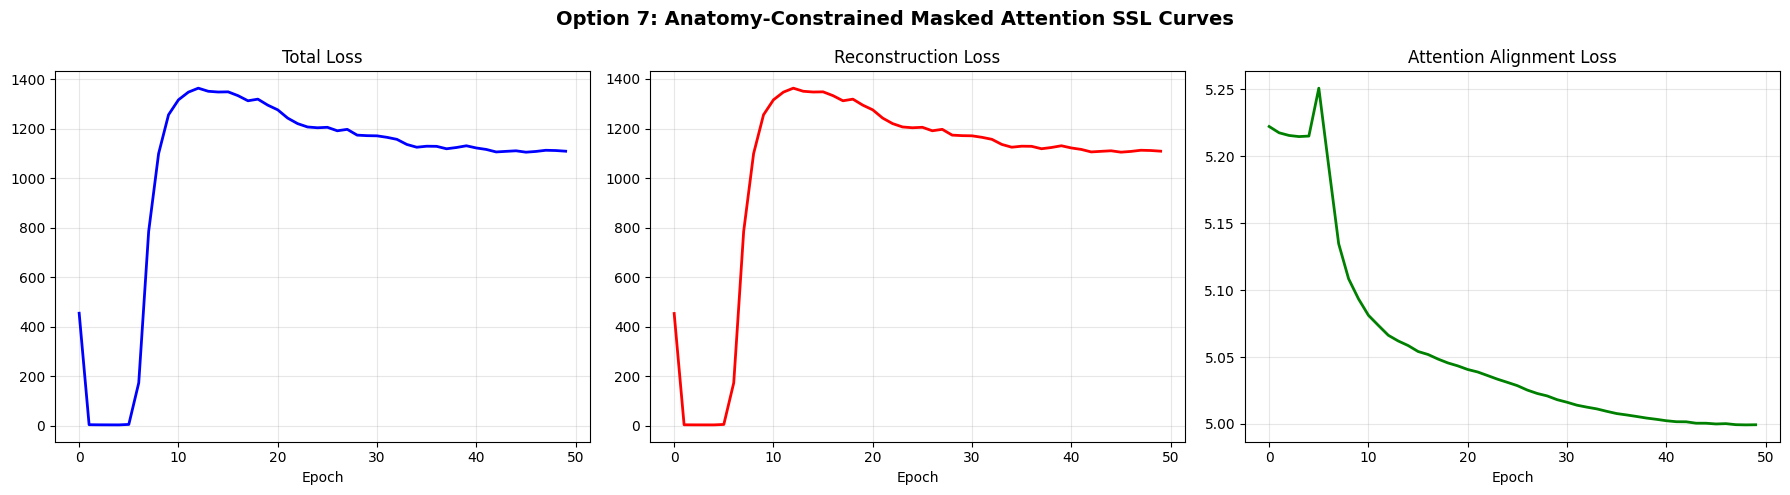

✅ Pretrained model saved


In [12]:
# ============================================
# 📈 Step 11: Plot SSL Training Curves & Save Pretrained Model
# ============================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(ssl_history['loss'], 'b-', linewidth=2)
axes[0].set_title('Total Loss', fontsize=12)
axes[0].set_xlabel('Epoch')
axes[0].grid(True, alpha=0.3)

axes[1].plot(ssl_history['recon_loss'], 'r-', linewidth=2)
axes[1].set_title('Reconstruction Loss', fontsize=12)
axes[1].set_xlabel('Epoch')
axes[1].grid(True, alpha=0.3)

axes[2].plot(ssl_history['attn_loss'], 'g-', linewidth=2)
axes[2].set_title('Attention Alignment Loss', fontsize=12)
axes[2].set_xlabel('Epoch')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Option 7: Anatomy-Constrained Masked Attention SSL Curves',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OPTION_NAME}_ssl_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# Save pretrained encoder
save_checkpoint({
    'online_encoder': online_encoder.state_dict(),
    'teacher_encoder': teacher_encoder.state_dict(),
    'config': vars(cfg),
}, f'{OPTION_NAME}_ssl_pretrained.pth')
print(f"✅ Pretrained model saved")

In [13]:
# ============================================
# 🎯 Step 12: Fine-tuning for Classification
# ============================================

# Freeze/unfreeze strategy: unfreeze with differential LR
for param in online_encoder.parameters():
    param.requires_grad = True

classifier = Classifier(cfg.embed_dim, len(DISEASE_CATEGORIES)).to(cfg.device)

# Differential learning rate
encoder_params = list(online_encoder.parameters())
classifier_params = list(classifier.parameters())

optimizer_ft = torch.optim.AdamW([
    {'params': encoder_params, 'lr': cfg.lr_finetune * 0.1},
    {'params': classifier_params, 'lr': cfg.lr_finetune},
], weight_decay=1e-4)

scheduler_ft = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_ft, mode='max', factor=0.3, patience=5, min_lr=1e-7, verbose=True
)

# Focal Loss for class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, targets):
        bce = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        pt = torch.exp(-bce)
        focal = self.alpha * (1 - pt) ** self.gamma * bce
        return focal.mean()

criterion_ft = FocalLoss(alpha=1, gamma=2)

finetune_history = {'train_loss': [], 'train_auc': [], 'val_loss': [], 'val_auc': []}
best_val_auc = 0.0
ft_start_epoch = 1
patience_counter = 0
EARLY_STOP_PATIENCE = 15

# Resume finetuning
if RESUME_FINETUNING:
    ckpt = load_checkpoint(f'{OPTION_NAME}_finetune_latest.pth')
    if ckpt is not None:
        online_encoder.load_state_dict(ckpt['online_encoder'])
        classifier.load_state_dict(ckpt['classifier'])
        optimizer_ft.load_state_dict(ckpt['optimizer'])
        finetune_history = ckpt.get('finetune_history', finetune_history)
        best_val_auc = ckpt.get('best_val_auc', 0.0)
        patience_counter = ckpt.get('patience_counter', 0)
        ft_start_epoch = ckpt['epoch'] + 1
        print(f"✅ Resumed fine-tuning from epoch {ft_start_epoch}")
    else:
        print("🆕 Starting fine-tuning from scratch")

print(f"\n{'='*60}")
print(f"🎯 FINE-TUNING: {OPTION_NAME}")
print(f"{'='*60}")

for epoch in range(ft_start_epoch, cfg.finetune_epochs + 1):
    # ── Train ──
    online_encoder.train()
    classifier.train()
    train_loss = 0.0
    train_preds, train_targets = [], []

    loader = tqdm(train_loader, desc=f"FT Epoch {epoch}") if not IN_KAGGLE else train_loader
    for images, targets in loader:
        images, targets = images.to(cfg.device), targets.to(cfg.device)

        tokens = online_encoder(images)
        cls_token = tokens[:, 0, :]  # CLS token
        logits = classifier(cls_token)

        loss = criterion_ft(logits, targets)

        optimizer_ft.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(online_encoder.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_(classifier.parameters(), 1.0)
        optimizer_ft.step()

        train_loss += loss.item()
        train_preds.append(torch.sigmoid(logits).detach().cpu())
        train_targets.append(targets.cpu())

    # ── Validate ──
    online_encoder.eval()
    classifier.eval()
    val_loss = 0.0
    val_preds, val_targets = [], []

    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(cfg.device), targets.to(cfg.device)
            tokens = online_encoder(images)
            cls_token = tokens[:, 0, :]
            logits = classifier(cls_token)
            loss = criterion_ft(logits, targets)
            val_loss += loss.item()
            val_preds.append(torch.sigmoid(logits).cpu())
            val_targets.append(targets.cpu())

    # Metrics
    train_preds = torch.cat(train_preds).numpy()
    train_targets = torch.cat(train_targets).numpy()
    val_preds = torch.cat(val_preds).numpy()
    val_targets = torch.cat(val_targets).numpy()

    train_auc = np.mean([roc_auc_score(train_targets[:, i], train_preds[:, i])
                         for i in range(len(DISEASE_CATEGORIES))
                         if len(np.unique(train_targets[:, i])) > 1])
    val_auc = np.mean([roc_auc_score(val_targets[:, i], val_preds[:, i])
                       for i in range(len(DISEASE_CATEGORIES))
                       if len(np.unique(val_targets[:, i])) > 1])

    finetune_history['train_loss'].append(train_loss / len(train_loader))
    finetune_history['train_auc'].append(train_auc)
    finetune_history['val_loss'].append(val_loss / len(val_loader))
    finetune_history['val_auc'].append(val_auc)

    scheduler_ft.step(val_auc)
    print(f"Epoch {epoch}: Train AUC={train_auc:.4f}, Val AUC={val_auc:.4f}")

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        patience_counter = 0
        save_checkpoint({
            'online_encoder': online_encoder.state_dict(),
            'classifier': classifier.state_dict(),
            'val_auc': val_auc,
            'epoch': epoch,
            'phase': 'best_model'
        }, f'{OPTION_NAME}_best_model.pth')
        print(f"  ✅ Best model saved! Val AUC: {val_auc:.4f}")
    else:
        patience_counter += 1

    if epoch % SAVE_EVERY_FT == 0 or epoch == cfg.finetune_epochs:
        save_checkpoint({
            'epoch': epoch,
            'online_encoder': online_encoder.state_dict(),
            'classifier': classifier.state_dict(),
            'optimizer': optimizer_ft.state_dict(),
            'finetune_history': finetune_history,
            'best_val_auc': best_val_auc,
            'patience_counter': patience_counter,
            'phase': 'finetuning'
        }, f'{OPTION_NAME}_finetune_latest.pth')

    if patience_counter >= EARLY_STOP_PATIENCE:
        print(f"⏹️  Early stopping at epoch {epoch} (no improvement for {EARLY_STOP_PATIENCE} epochs)")
        break

print(f"\n🏆 Best Validation AUC: {best_val_auc:.4f}")

✅ Resumed fine-tuning from epoch 26

🎯 FINE-TUNING: option7_anatomy_masked_attention_ssl


FT Epoch 26: 100%|██████████| 1620/1620 [02:41<00:00, 10.04it/s]


Epoch 26: Train AUC=0.8992, Val AUC=0.7702
⏹️  Early stopping at epoch 26 (no improvement for 15 epochs)

🏆 Best Validation AUC: 0.7992


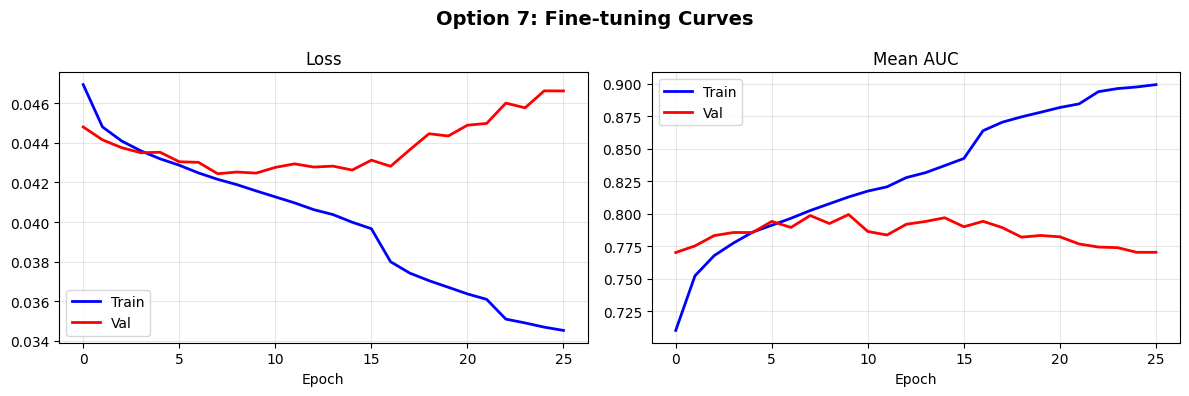

In [14]:
# ============================================
# 📊 Step 13: Plot Fine-tuning Curves
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(finetune_history['train_loss'], 'b-', label='Train', linewidth=2)
axes[0].plot(finetune_history['val_loss'], 'r-', label='Val', linewidth=2)
axes[0].set_title('Loss', fontsize=12)
axes[0].set_xlabel('Epoch')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(finetune_history['train_auc'], 'b-', label='Train', linewidth=2)
axes[1].plot(finetune_history['val_auc'], 'r-', label='Val', linewidth=2)
axes[1].set_title('Mean AUC', fontsize=12)
axes[1].set_xlabel('Epoch')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Option 7: Fine-tuning Curves', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OPTION_NAME}_finetune_curves.png', dpi=150, bbox_inches='tight')
plt.show()

📊 TEST SET EVALUATION


Evaluating on TEST set: 100%|██████████| 36/36 [00:05<00:00,  7.02it/s]



🎯 OPTIMAL THRESHOLDS:
----------------------------------------
Atelectasis         : 0.384
Cardiomegaly        : 0.403
Effusion            : 0.351
Infiltration        : 0.371
Mass                : 0.337
Nodule              : 0.342
Pneumonia           : 0.260
Pneumothorax        : 0.416
Consolidation       : 0.343
Edema               : 0.402
Emphysema           : 0.263
Fibrosis            : 0.282
Pleural_Thickening  : 0.304
Hernia              : 0.166

📊 PER-DISEASE METRICS (TEST SET):
Atelectasis         : AUC=0.7464 | F1=0.3184 | Prec=0.2447 | Rec=0.4558
Cardiomegaly        : AUC=0.9230 | F1=0.4825 | Prec=0.4460 | Rec=0.5254
Effusion            : AUC=0.8559 | F1=0.5283 | Prec=0.4098 | Rec=0.7434
Infiltration        : AUC=0.6766 | F1=0.3749 | Prec=0.3196 | Rec=0.4532
Mass                : AUC=0.8256 | F1=0.3400 | Prec=0.2787 | Rec=0.4359
Nodule              : AUC=0.6335 | F1=0.1638 | Prec=0.2088 | Rec=0.1348
Pneumonia           : AUC=0.7192 | F1=0.0811 | Prec=0.0667 | Rec=0.1034
Pneum

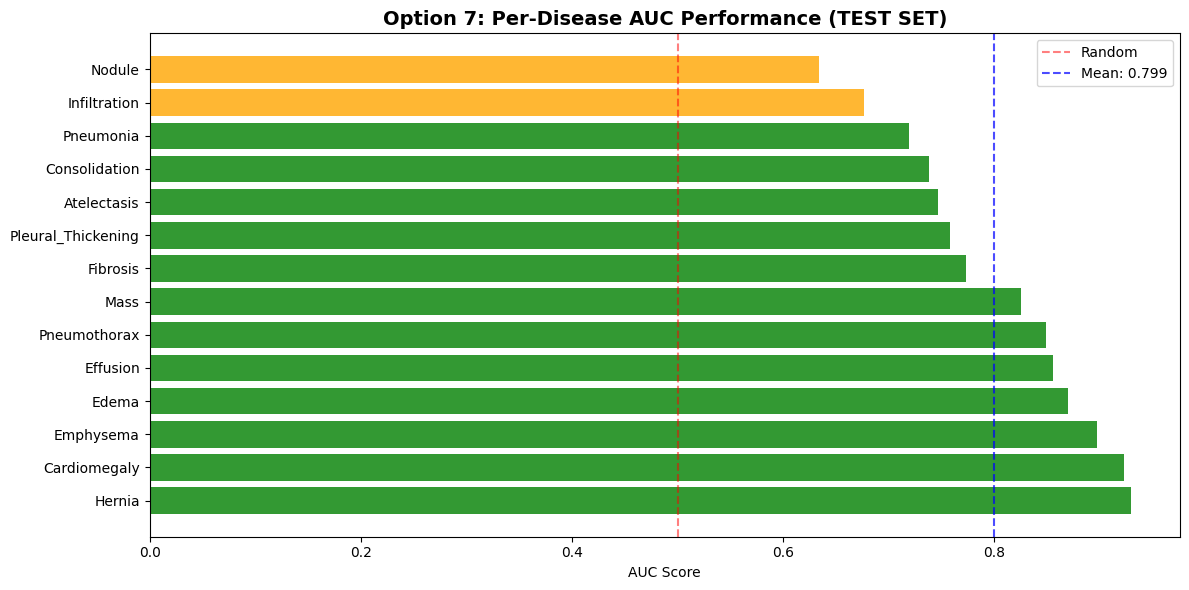

In [15]:
# ============================================
# 📈 Step 14: Final Evaluation on TEST SET
# ============================================

best_model_path = os.path.join(CHECKPOINT_DIR, f'{OPTION_NAME}_best_model.pth')
checkpoint = torch.load(best_model_path, map_location=cfg.device, weights_only=False)
online_encoder.load_state_dict(checkpoint['online_encoder'])
classifier.load_state_dict(checkpoint['classifier'])

online_encoder.eval()
classifier.eval()

print("=" * 60)
print("📊 TEST SET EVALUATION")
print("=" * 60)

all_preds, all_targets = [], []
with torch.no_grad():
    loader = tqdm(test_loader, desc="Evaluating on TEST set") if not IN_KAGGLE else test_loader
    for images, targets in loader:
        images = images.to(cfg.device)
        tokens = online_encoder(images)
        cls_token = tokens[:, 0, :]
        logits = classifier(cls_token)
        all_preds.append(torch.sigmoid(logits).cpu())
        all_targets.append(targets)

all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

# Optimal thresholds
print("\n🎯 OPTIMAL THRESHOLDS:")
print("-" * 40)
optimal_thresholds = {}
for i, disease in enumerate(DISEASE_CATEGORIES):
    if len(np.unique(all_targets[:, i])) > 1:
        precision, recall, thresholds = precision_recall_curve(all_targets[:, i], all_preds[:, i])
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        best_idx = np.argmax(f1_scores)
        best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
    else:
        best_threshold = 0.5
    optimal_thresholds[disease] = best_threshold
    print(f"{disease:20s}: {best_threshold:.3f}")

# Per-disease metrics
print("\n📊 PER-DISEASE METRICS (TEST SET):")
print("=" * 60)
auc_scores, f1_scores_list = [], []
for i, disease in enumerate(DISEASE_CATEGORIES):
    if len(np.unique(all_targets[:, i])) > 1:
        auc = roc_auc_score(all_targets[:, i], all_preds[:, i])
        pred_binary = (all_preds[:, i] > optimal_thresholds[disease]).astype(int)
        f1 = f1_score(all_targets[:, i], pred_binary)
        prec = precision_score(all_targets[:, i], pred_binary, zero_division=0)
        rec = recall_score(all_targets[:, i], pred_binary, zero_division=0)
        auc_scores.append(auc)
        f1_scores_list.append(f1)
        print(f"{disease:20s}: AUC={auc:.4f} | F1={f1:.4f} | Prec={prec:.4f} | Rec={rec:.4f}")

mean_auc = np.mean(auc_scores)
mean_f1 = np.mean(f1_scores_list)

print("\n" + "=" * 60)
print(f"🏆 TEST SET RESULTS:")
print(f"   Mean AUC: {mean_auc:.4f}")
print(f"   Mean F1:  {mean_f1:.4f}")
print("=" * 60)

# AUC bar chart
auc_data = list(zip(DISEASE_CATEGORIES, auc_scores))
auc_data.sort(key=lambda x: x[1], reverse=True)
diseases, aucs = zip(*auc_data)

plt.figure(figsize=(12, 6))
colors = ['green' if a >= 0.7 else 'orange' if a >= 0.6 else 'red' for a in aucs]
plt.barh(diseases, aucs, color=colors, alpha=0.8)
plt.axvline(0.5, color='red', linestyle='--', alpha=0.5, label='Random')
plt.axvline(mean_auc, color='blue', linestyle='--', alpha=0.7, label=f'Mean: {mean_auc:.3f}')
plt.xlabel('AUC Score')
plt.title('Option 7: Per-Disease AUC Performance (TEST SET)', fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.savefig(f'{OPTION_NAME}_auc_performance.png', dpi=150, bbox_inches='tight')
plt.show()

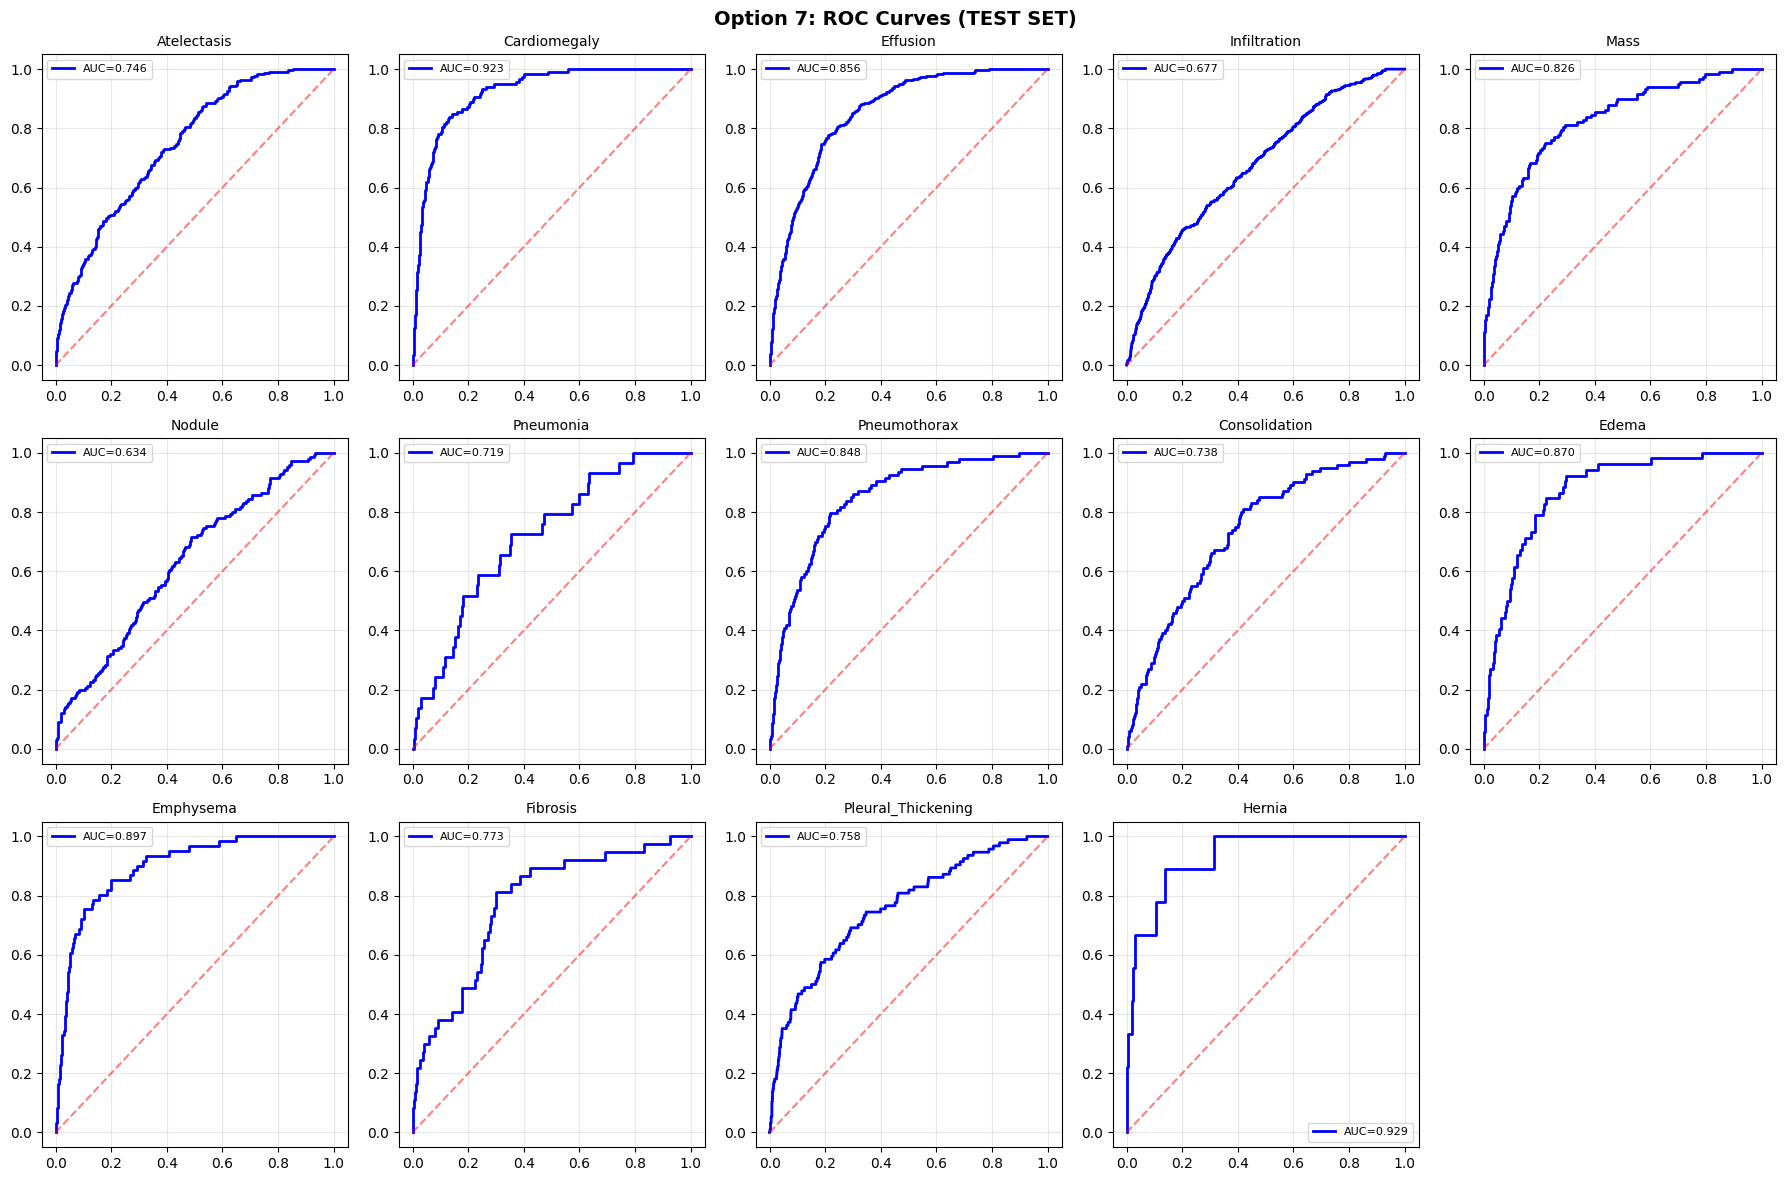

In [16]:
# ============================================
# 📈 Step 15: ROC Curves Visualization
# ============================================
from sklearn.metrics import roc_curve, auc

n_diseases = len(DISEASE_CATEGORIES)
n_cols = 5
n_rows = (n_diseases + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()

for i, disease in enumerate(DISEASE_CATEGORIES):
    if len(np.unique(all_targets[:, i])) > 1:
        fpr, tpr, _ = roc_curve(all_targets[:, i], all_preds[:, i])
        roc_auc = auc(fpr, tpr)
        axes[i].plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC={roc_auc:.3f}')
        axes[i].plot([0, 1], [0, 1], 'r--', alpha=0.5)
        axes[i].set_title(disease, fontsize=10)
        axes[i].legend(fontsize=8)
        axes[i].grid(True, alpha=0.3)

# Hide unused axes
for j in range(n_diseases, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Option 7: ROC Curves (TEST SET)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OPTION_NAME}_roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

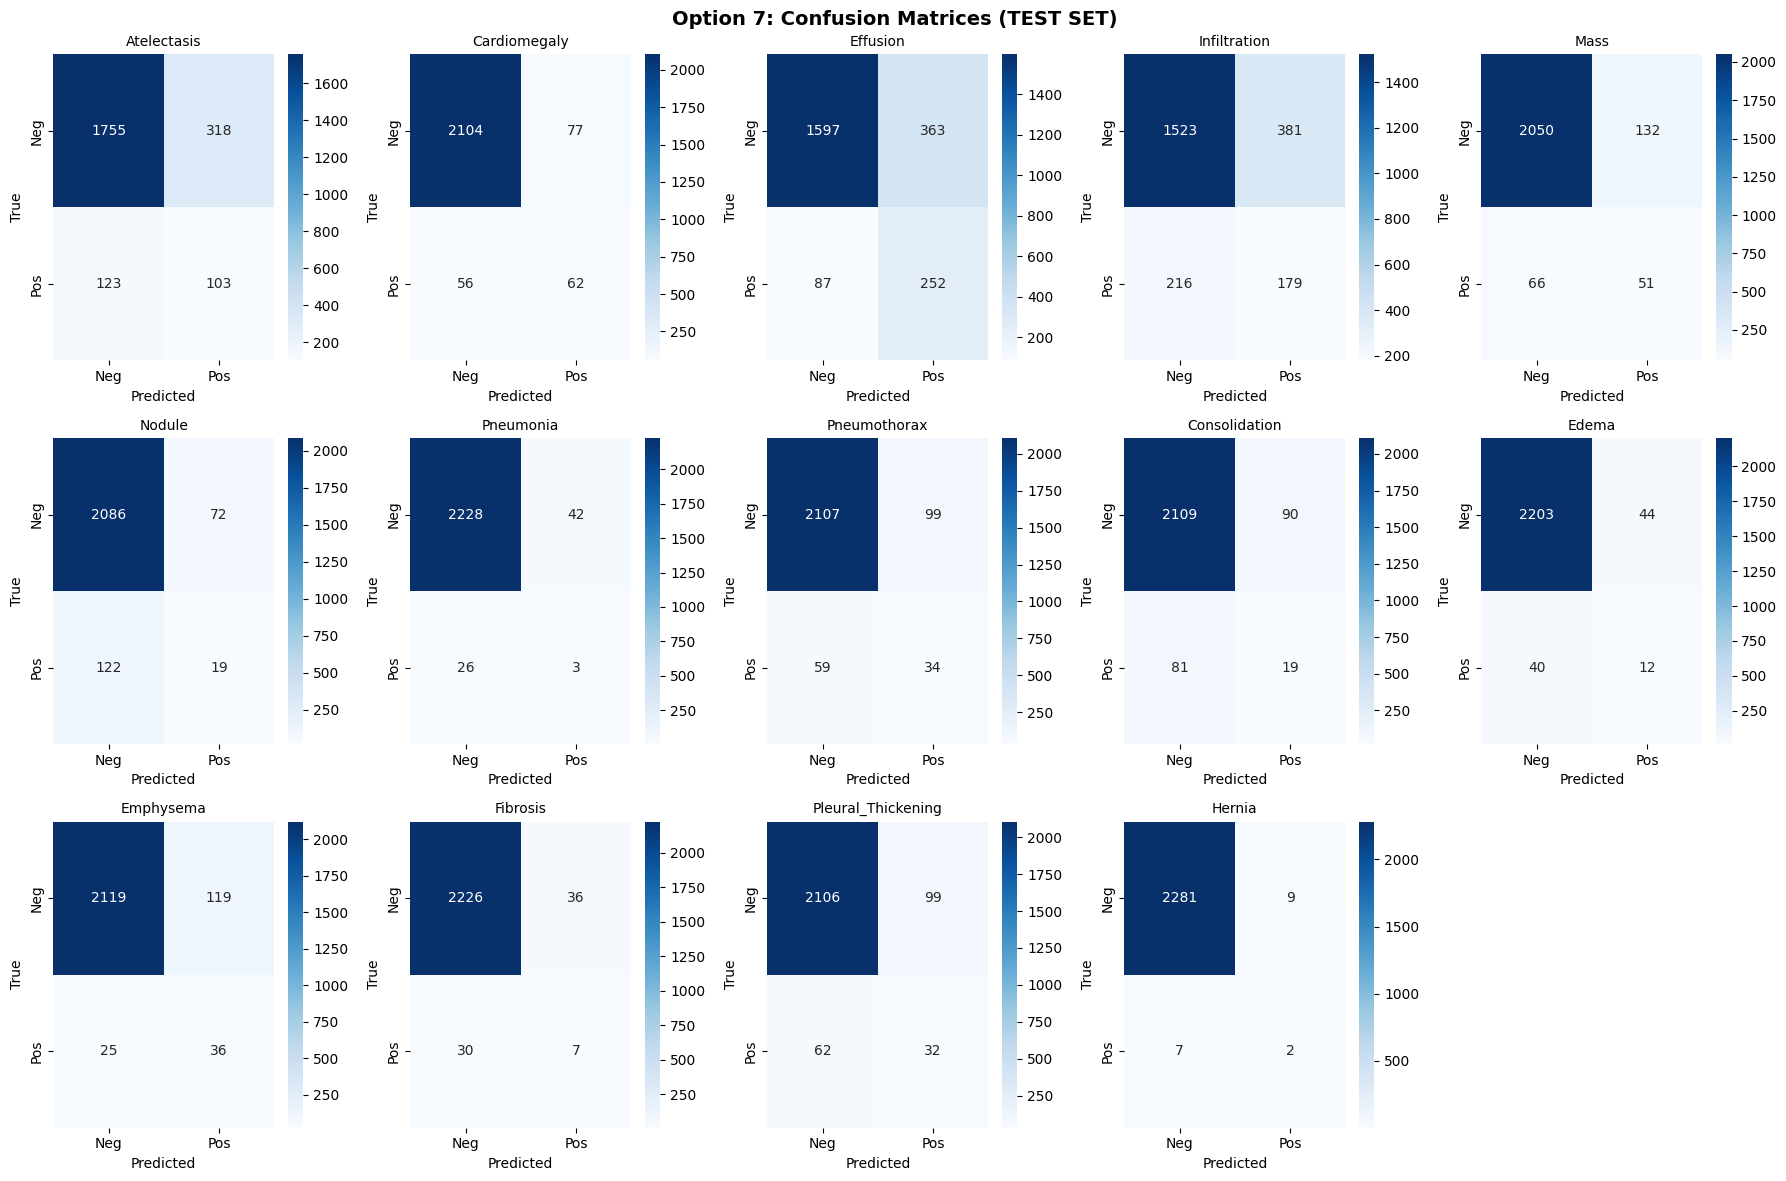

In [17]:
# ============================================
# 🎨 Step 16: Confusion Matrices Visualization
# ============================================
from sklearn.metrics import confusion_matrix

test_preds_binary = np.zeros_like(all_preds)
for i, disease in enumerate(DISEASE_CATEGORIES):
    thresh = optimal_thresholds.get(disease, 0.5)
    test_preds_binary[:, i] = (all_preds[:, i] > thresh).astype(int)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()

for i, disease in enumerate(DISEASE_CATEGORIES):
    if len(np.unique(all_targets[:, i])) > 1:
        cm = confusion_matrix(all_targets[:, i], test_preds_binary[:, i])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                    xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
        axes[i].set_title(disease, fontsize=10)
        axes[i].set_ylabel('True')
        axes[i].set_xlabel('Predicted')

for j in range(n_diseases, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Option 7: Confusion Matrices (TEST SET)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OPTION_NAME}_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

In [18]:
# ============================================
# 📝 Step 17: Summary
# ============================================

print("\n" + "=" * 60)
print("📝 OPTION 7: ANATOMY-CONSTRAINED MASKED ATTENTION SSL SUMMARY")
print("=" * 60)
print(f"\nMethod: ViT + Momentum Teacher + Lung-Aware Masking + Attention Alignment")
print(f"Dataset: NIH Chest X-ray 14")
print(f"Training samples: {len(train_df):,}")
print(f"Validation samples: {len(val_df):,}")
print(f"Test samples: {len(test_df):,}")
print(f"\nPretraining epochs: {cfg.pretrain_epochs}")
print(f"Fine-tuning epochs: {cfg.finetune_epochs}")
print(f"\n🔧 Key Components:")
print(f"   ✅ ViT-Tiny encoder (embed_dim={cfg.embed_dim}, depth={cfg.depth})")
print(f"   ✅ Momentum teacher (EMA m={cfg.momentum})")
print(f"   ✅ Lung-aware masking (mask_ratio={cfg.mask_ratio})")
print(f"   ✅ Attention alignment (λ={cfg.lambda_attn})")
print(f"   ✅ Latent-space reconstruction loss")
print(f"   ✅ KL divergence attention regularization")
print(f"   ✅ Patient-level data splits")
print(f"   ✅ Focal Loss for class imbalance")
print(f"   ✅ Differential learning rates")
print(f"   ✅ Per-disease optimal thresholds")
print(f"\n🏆 TEST SET Mean AUC: {mean_auc:.4f}")
print(f"🏆 TEST SET Mean F1:  {mean_f1:.4f}")
print(f"\nFiles saved:")
print(f"  - {OPTION_NAME}_ssl_pretrained.pth")
print(f"  - {OPTION_NAME}_best_model.pth")
print(f"  - {OPTION_NAME}_ssl_curves.png")
print(f"  - {OPTION_NAME}_finetune_curves.png")
print(f"  - {OPTION_NAME}_auc_performance.png")
print(f"  - {OPTION_NAME}_roc_curves.png")
print(f"  - {OPTION_NAME}_confusion_matrices.png")
print("=" * 60)


📝 OPTION 7: ANATOMY-CONSTRAINED MASKED ATTENTION SSL SUMMARY

Method: ViT + Momentum Teacher + Lung-Aware Masking + Attention Alignment
Dataset: NIH Chest X-ray 14
Training samples: 103,634
Validation samples: 6,187
Test samples: 2,299

Pretraining epochs: 50
Fine-tuning epochs: 100

🔧 Key Components:
   ✅ ViT-Tiny encoder (embed_dim=384, depth=12)
   ✅ Momentum teacher (EMA m=0.996)
   ✅ Lung-aware masking (mask_ratio=0.5)
   ✅ Attention alignment (λ=0.05)
   ✅ Latent-space reconstruction loss
   ✅ KL divergence attention regularization
   ✅ Patient-level data splits
   ✅ Focal Loss for class imbalance
   ✅ Differential learning rates
   ✅ Per-disease optimal thresholds

🏆 TEST SET Mean AUC: 0.7995
🏆 TEST SET Mean F1:  0.2848

Files saved:
  - option7_anatomy_masked_attention_ssl_ssl_pretrained.pth
  - option7_anatomy_masked_attention_ssl_best_model.pth
  - option7_anatomy_masked_attention_ssl_ssl_curves.png
  - option7_anatomy_masked_attention_ssl_finetune_curves.png
  - option7_ana